<a href="https://colab.research.google.com/github/jsjang00/Pytorch/blob/main/Resnet_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/catndog.zip 파일 선택
!unzip catanddog.zip -d catanddog/    #catanddog 폴더 만들어 압축 풀기

In [2]:
#----------------------전처리,데이터 불러오기---------------------------------
data_path = 'catanddog/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),#256*256
                    transforms.RandomResizedCrop(224),#Random Crop
                    transforms.RandomHorizontalFlip(),#수평으로 뒤집기
                    transforms.ToTensor(),#텐서로 변환
                ])
trainset = torchvision.datasets.ImageFolder(data_path,transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(trainset))

385


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
#----------------------trainset 샘플 출력---------------------------------
images, labels = iter(trainloader).next()
print(images.shape,labels.shape)
classes = {0:'cat', 1:'dog'}

# function for showing image
fig = plt.figure(figsize=(16,24))
rows=4
cols=6

for i in range(rows*cols):
    a = fig.add_subplot(rows,cols,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(images[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [4]:
resnet18 = models.resnet18(pretrained=True) # pretrained parameters
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False #파라미터 학습 x -> 모델 일부를 고정
            
set_parameter_requires_grad(resnet18)
resnet18.fc = nn.Linear(512, 2)#output class==2
for name, param in resnet18.named_parameters(): #모델에 접근해 파라미터 값들을 가져올때 
    if param.requires_grad:
        print(name, param.data)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

fc.weight tensor([[-0.0339,  0.0332, -0.0175,  ...,  0.0234, -0.0256, -0.0142],
        [-0.0162, -0.0109, -0.0237,  ...,  0.0201, -0.0382, -0.0165]])
fc.bias tensor([-0.0422,  0.0286])


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #GPU
model = models.resnet18(pretrained = True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)

for param in model.fc.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [18]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()    
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        running_loss = 0.0  # Epoch당 0으로 초기화
        running_corrects = 0 #맞힌 개수

        for i,(inputs, labels) in enumerate(dataloaders, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)

            # 기울기 초기화
            optimizer.zero_grad()
            # 순전파 + 손실함수계산 + 역전파 + 학습
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() 
            running_corrects += torch.sum(preds == labels.data) # 출력 결과와 답이 동일한지(맞힌 개수)저장

        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}' )

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        loss_history.append(epoch_loss)        
        torch.save(model.state_dict(), os.path.join('catanddog/', '{0:0=2d}.pth'.format(epoch)))#모델 저장
        print()

    #시간 출력

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s' )
    print(f'Best Acc: {best_acc:4f}')    
    return acc_history, loss_history

In [22]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print(name)
            
optimizer = optim.Adam(params_to_update) # fc parameter는 학습에 사용

fc.weight
fc.bias


In [23]:
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(model, trainloader, criterion, optimizer, device)

Epoch 0/12
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Loss: 0.0169 Acc: 0.7948

Epoch 1/12
----------
Loss: 0.0123 Acc: 0.8623

Epoch 2/12
----------
Loss: 0.0126 Acc: 0.8571

Epoch 3/12
----------
Loss: 0.0091 Acc: 0.9091

Epoch 4/12
----------
Loss: 0.0088 Acc: 0.9169

Epoch 5/12
----------
Loss: 0.0084 Acc: 0.9247

Epoch 6/12
----------
Loss: 0.0077 Acc: 0.9247

Epoch 7/12
----------
Loss: 0.0078 Acc: 0.9117

Epoch 8/12
----------
Loss: 0.0082 Acc: 0.9273

Epoch 9/12
----------
Loss: 0.0099 Acc: 0.8857

Epoch 10/12
----------
Loss: 0.0078 Acc: 0.9169

Epoch 11/12
----------
Loss: 0.0084 Acc: 0.8883

Epoch 12/12
----------
Loss: 0.0066 Acc: 0.9351

Training complete in 0m 38s
Best Acc: 0.935065


In [24]:
test_path = 'catanddog/test/'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [25]:
def eval_model(model, dataloaders, device):
    since = time.time()    
    acc_history = []
    best_acc = 0.0

    saved_models = glob.glob('catanddog/' + '*.pth')
    saved_models.sort()
    print('saved_model', saved_models)

    for model_path in saved_models:
        print('Loading model', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        correct = 0

        for i,(inputs, labels) in enumerate(dataloaders, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): #autograd 사용 x
                outputs = model(inputs)

            _, predicted= torch.max(outputs.data, 1) 
            if i%10==0:
              print(predicted)      # (1*32) size    
            correct += (predicted == labels).sum().item() #32개 중에 몇개 맞췄는지
            
        epoch_acc = correct / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_history.append(epoch_acc)
        print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history

In [27]:
val_acc_hist = eval_model(model, test_loader, device)

saved_model ['catanddog/00.pth', 'catanddog/01.pth', 'catanddog/02.pth', 'catanddog/03.pth', 'catanddog/04.pth', 'catanddog/05.pth', 'catanddog/06.pth', 'catanddog/07.pth', 'catanddog/08.pth', 'catanddog/09.pth', 'catanddog/10.pth', 'catanddog/11.pth', 'catanddog/12.pth']
Loading model catanddog/00.pth
tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Acc: 0.7959

Loading model catanddog/01.pth
tensor([0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
Acc: 0.8980

Loading model catanddog/02.pth
tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
Acc: 0.9082

Loading model catanddog/03.pth
tensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
Acc: 0.9184

Loading model catanddog/04.pth


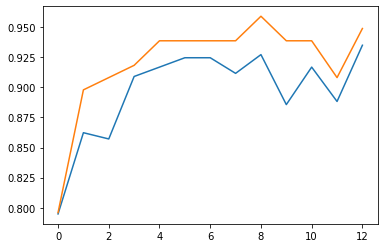

In [28]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

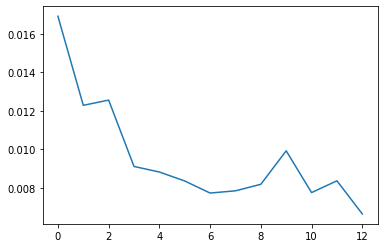

In [29]:
plt.plot(train_loss_hist)
plt.show()

In [30]:
def  im_convert(tensor):  
    image=tensor.clone().detach().numpy()  
    image=image.transpose(1,2,0)  
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image=image.clip(0,1)  
    return image  

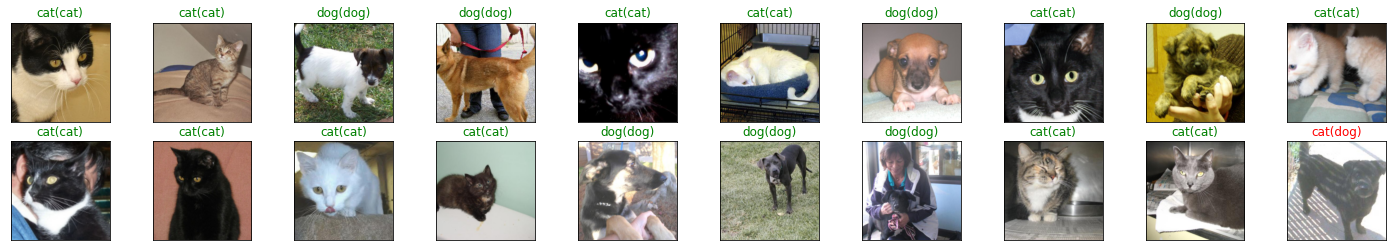

<Figure size 432x288 with 0 Axes>

In [32]:
classes = {0:'cat', 1:'dog'}

dataiter=iter(test_loader)  
images,labels=dataiter.next()  
model.to('cpu')
output=model(images)  
_,preds=torch.max(output,1) 

fig=plt.figure(figsize=(25,4))  
for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(images[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("{}({})".format(str(classes[preds[idx].item()]),str(classes[labels[idx].item()])),color=("green" if preds[idx]==labels[idx] else "red"))  
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)